In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.io import imshow

In [2]:
def RGBtoYCbCr (R, G, B):
    R = int(R)
    G = int(G)
    B = int(B)
    R /= 255.0
    G /= 255.0
    B /= 255.0
    Y = 16 + (65.481 * R + 128.553 * G + 24.966 * B)
    Cb = 128 + (-37.797 * R - 74.203 * G + 112.0 * B)
    Cr = 128 + (112.0 * R - 93.786 * G - 18.214 * B)
    return Y, Cb, Cr

In [3]:
path = './Skin_NonSkin.txt'
content = ""
with open(path, 'r') as file:
    content = file.read()
entries = content.split('\n')
dataset = dict()
for line in entries:
    if line:
        R, G, B, label = line.split()
        label = int(label)
        if(label not in dataset):
            dataset[label] = []
        Y, Cb, Cr = RGBtoYCbCr(R, G, B)
        dataset[label].append([Cb, Cr])

In [4]:
def get_mean_cov(dataset):
    mean = dict()
    cov = dict()
    for label in dataset:
        data = np.array(dataset[label])
        mean[label] = np.mean(data, axis=0)
        cov[label] = np.cov(data, rowvar=False)
    return mean, cov
mean, cov = get_mean_cov(dataset)
skinMean = mean[1]
skinCov = cov[1]
nonSkinMean = mean[2]
nonSkinCov = cov[2]


In [5]:
def prob_c_label(C, mean, cov):
    C = np.array(C)
    C = C - mean
    return np.exp(-0.5 * np.dot(C.T,np.dot(np.linalg.inv(cov), C))) / (2 * np.pi * np.sqrt(np.linalg.det(cov)))
def prob_skin_c(C, skinMean, skinCov, nonSkinMean, nonSkinCov):
    probCskin = prob_c_label(C, skinMean, skinCov)
    probCnonSkin = prob_c_label(C, nonSkinMean, nonSkinCov)
    return probCskin / (probCskin + probCnonSkin)


In [6]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

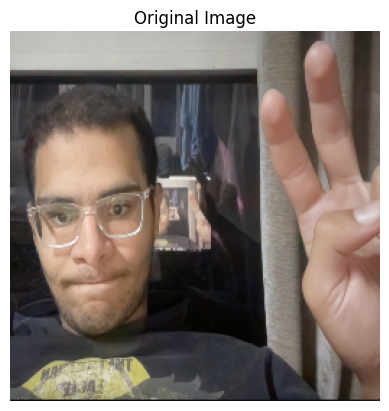

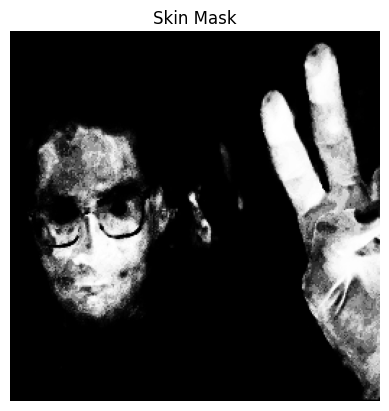

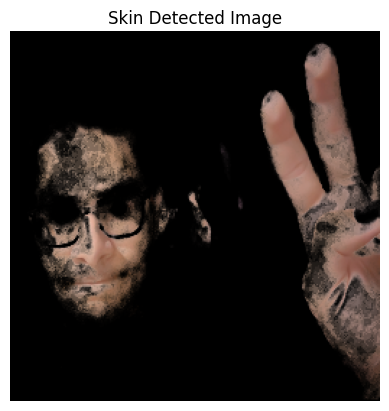

In [7]:
image = cv2.imread('/Users/zeyaddaowd/Desktop/sora2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))
YCC = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
image = image.astype(np.float64) / 255
C = YCC[:, :, 1:]
skinMask = np.zeros((image.shape[0], image.shape[1]))
skinMask[0,0] = prob_skin_c(C[0,0], skinMean, skinCov, nonSkinMean, nonSkinCov)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        skinMask[i, j] = prob_skin_c(C[i,j], skinMean, skinCov, nonSkinMean, nonSkinCov)
show_images([image], ['Original Image'])
show_images([skinMask], ['Skin Mask'])
show_images([image * skinMask[:, :, np.newaxis]], ['Skin Detected Image'])


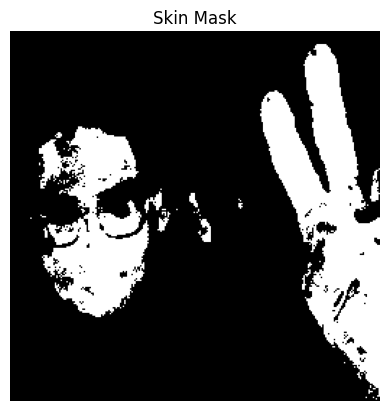

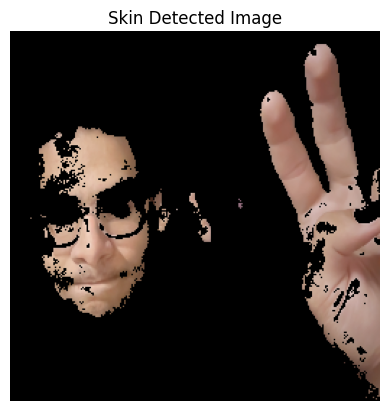

In [8]:
binaryMask = cv2.threshold(skinMask, 0.3, 1, cv2.THRESH_BINARY)[1]
show_images([binaryMask], ['Skin Mask'])
show_images([image * binaryMask[:, :, np.newaxis]], ['Skin Detected Image'])

In [14]:
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.resize(frame, (256, 256))
    cv2.imshow('Original Frame', frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    YCC = cv2.cvtColor(frame, cv2.COLOR_RGB2YCrCb)
    frame = frame.astype(np.float64) / 255
    C = YCC[:, :, 1:]
    skinMask = np.zeros((frame.shape[0], frame.shape[1]))
    for i in range(frame.shape[0]):
        for j in range(frame.shape[1]):
            skinMask[i, j] = prob_skin_c(C[i,j], skinMean, skinCov, nonSkinMean, nonSkinCov)
    binaryMask = cv2.threshold(skinMask, 0.3, 1, cv2.THRESH_BINARY)[1]
    cv2.imshow('Skin Detection', frame * binaryMask[:, :, np.newaxis])
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

KeyboardInterrupt: 

In [10]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cv2.imshow('Face Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

2024-12-07 17:14:50.321 Python[3738:13524566] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
